In [176]:
# imports
import math
import numpy as np
import pandas as pd
from scipy import stats
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
# import mayavi.mlab as mlab
import seaborn as sns

import sys
import json
import shutil

In [57]:
def load_parameters(filepath):
    '''
    Loads input and output directories
    '''
    with open(filepath) as fp:
        parameter = json.load(fp)

    return parameter

sys.path.insert(0, '../src')

In [241]:
# Seating_chart_builder

n = 28
seats = {str(i): 0 for i in range(n)}
seats_28 = seats.copy()
for key, val in seats.items():    
    if int(key)%4 == 0:
        x = int(7/2 * int(key) + 2)
        y = 3
            
    elif int(key)%4 == 1:
        x = int(7/2 * (int(key) - 1) + 2)
        y = 16
        
    elif int(key)%4 == 2:
        x = int(7/2 * int(key) + 2)
        y = 8
        
    else:
        x = int(7/2 * (int(key) - 1) + 2)
        y = 21
    seats_28[key] = [x, y]
    
n_ = 56
seats_ = {str(i): 0 for i in range(n_)}
seats_56 = seats_.copy()
for key, val in seats_.items():
    if int(key)%4 == 0:
        x = int(7 * int(key)/4 + 2)
        y = 3
            
    elif int(key)%4 == 1:
        x = int(7 * (int(key) - 1)/4 + 2)
        y = 16
        
    elif int(key)%4 == 2:
        x = int(7 * int(key)/4 -1)
        y = 8
        
    else:
        x = int(7 * (int(key) - 1)/4 -1)
        y = 21
    seats_56[key] = [x, y]
# ----------------------------------------------------------
f_seats = {str(i): [] for i in range(56)}
f_seats_28 = f_seats.copy()
for key, val in f_seats.items(): 
    if int(key)%4 == 0:
        x = math.floor(int(key)/2)  + math.floor(int(key)/6) + 1
        y = 1
            
    elif int(key)%4 == 1:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 4
        
    elif int(key)%4 == 2:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 2
        
    else:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 5
    f_seats_28[key] = [x, y]
    
f_seats_ = {str(i): [] for i in range(n_)}
f_seats_56 = f_seats_.copy()
for key, val in f_seats_56.items():
    if int(key)%4 == 0:
        x = math.floor(int(key)/4)  + math.floor(int(key)/12) + 1
        y = 1
            
    elif int(key)%4 == 1:
        x = math.floor(int(key) - 1)/4  + math.floor((int(key) - 1)/12) + 1
        y = 4
        
    elif int(key)%4 == 2:
        x = math.floor(int(key)/4)  + math.floor(int(key)/12) + 1
        y = 2
        
    else:
        x = math.floor((int(key) -1)/4)  + math.floor((int(key) - 1)/12) + 1
        y = 5
    f_seats_56[key] = [int(x), int(y)]

In [242]:
# LOCAL IMPORT
# import data from other files
from bus import bus_sim, trip_stats
from classroom import func
from infection import generate_infectivity_curves, plot_infectivity_curves, return_aerosol_transmission_rate

In [243]:
# INFECTION

# plot % infectivity based on day- lognormal w/ % chance of infectivity

# proxy_vars = generate_infectivity_curves()
# out = plot_infectivity_curves(proxy_vars)
# proxy_vars
out

,x,gamma
0,-10.0,3.584841e-09
1,-9.0,1.170157e-06
2,-8.0,4.868625e-05
3,-7.0,6.372789e-04
4,-6.0,3.973076e-03
5,-5.0,1.477747e-02
6,-4.0,3.756865e-02
7,-3.0,7.132390e-02
8,-2.0,1.074581e-01
9,-1.0,1.342055e-01


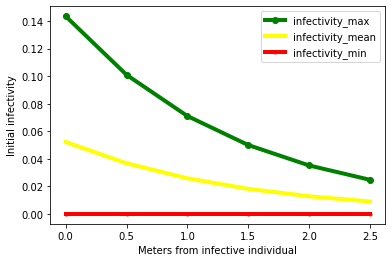

In [244]:
# print('max', max(out))
# print('min', min(out))
# print('mean', np.mean(out))
dist_plot_x = np.arange(0, 3, 0.5)
def chu(dist, inf):
    return (1 / (2.02 ** dist)) * inf
max_list = []
min_list = []
mean_list = []



for i in dist_plot_x:
    max_list.append(chu(i, max(out.gamma)))
    min_list.append(chu(i, min(out.gamma)))
    mean_list.append(chu(i, np.mean(out.gamma)))
    

df = pd.DataFrame({'meters': dist_plot_x, 'infectivity_max': max_list, 'infectivity_mean': mean_list, 'infectivity_min': min_list})

plt.plot('meters', 'infectivity_max', data=df, marker='o', color='green', linewidth=4)
plt.plot('meters', 'infectivity_mean', data=df, marker='', color='yellow', linewidth=4)
plt.plot('meters', 'infectivity_min', data=df, marker='.', color='red', linewidth=4)    
plt.legend()
plt.xlabel('Meters from infective individual')
plt.ylabel('Initial infectivity')


# plt.show() 
plt.savefig("distance_infective.png", dpi=300)
# replace with plt.savefig()

In [245]:
############ initialize variables

# setup default infection parameters
floor_area = 86.02  # ft2 # 11.4 m * 2.3 m * (m^2->ft^2) = 86.02 ~= 86 ft^2
mean_ceiling_height = 12  # ft # 1.85 m -> ft = 6.06 ~= 6 ft
air_exchange_rate = 20  # /hr (air changes per hour (ACH)) #moving bus mph average


##Assumed Parameter Identified as 0.2 for Classrooms, 1.0 for outdoors#
# and .5 for buses with windows open
primary_outdoor_air_fraction = 0.5  # 1.0 = natural ventilation
aerosol_filtration_eff = 0  # >0.9997 HEPA, =0.2-0.9 MERVs, =0 no filter

#Average daily RH for San Diego is 69%
relative_humidity = 0.69 
physical_params = [floor_area, mean_ceiling_height, air_exchange_rate, primary_outdoor_air_fraction,
                        aerosol_filtration_eff, relative_humidity]

# Physiological Parameters
breathing_flow_rate = 0.5  # m3/hr
max_aerosol_radius = 2  # micrometers
physio_params = [breathing_flow_rate, max_aerosol_radius]

# Disease Parameters
exhaled_air_inf = 30  # infection quanta/m3, changes with acitivity type.
max_viral_deact_rate = 0.3  # /hr
disease_params = [exhaled_air_inf, max_viral_deact_rate]

# Precautionary Parameters
mask_passage_prob = .1 # 1 = no masks, ~0.1 cloth, <0.05 N95
risk_tolerance = 0.1  # expected transmissions per infector
prec_params = [mask_passage_prob, risk_tolerance]
############

In [394]:
select_dict = load_parameters('../config/neighbor_logic.json')

def get_neighbor_incoming(x, y, old):
    neighb = []
    count = 0
    x_max = len(old) - 1
    y_max = len(old[0]) - 1

    if x == 0:
        x_range = [0, 1]
    elif x == x_max:
        x_range = [-1, 0]
    else:
        x_range = [-1, 0, 1]

    if y == 0:
        y_range = [0, 1]
    elif y == y_max:
        y_range = [-1, 0]
    else:
        y_range = [-1, 0, 1]

    this_val = old[x][y]
    this_direction = bus_flow_direction[x][y]
    this_velocity = bus_flow_velocity[x][y]

    dict_iterate_count = 0
    for i in x_range:
        for j in y_range:
            dict_iterate_count += 1
            if i == 0 and j == 0:
                # disperse .1 to all 8 neighboring squares
                for direction in select_dict[str([i, j])]:
                    idx = select_dict[str([i, j])].index(direction)
                    vel_idx = bus_flow_velocity[x + i][y + j]
                    magnitude = .1
                    value = old[x + i][y + j]
                    neighb.append(value * magnitude)
            else:
                # factors in neighboring cell
                direction = bus_flow_direction[x + i][y + j]

                # update direction function

                if direction in select_dict[str([i, j])]:
                    idx = select_dict[str([i, j])].index(direction)
                    vel_idx = bus_flow_velocity[x + i][y + j]
                    magnitude = select_dict["mag_array"][vel_idx] * select_dict["risk_array"][idx]
                    value = old[x + i][y + j]
                    neighb.append(value * magnitude)
                # else nothing moves in

    if len(neighb) > 0:
        new_val = this_val * (1 - .2 * this_velocity) + np.mean(neighb)
    else:
        new_val = this_val
    return new_val

def air_effects(i, j, oldQ):
    '''
    i, j: x y locations

    oldQ: old quanta at that cube

    get neighbors directions and magnitude
    determine % in and % out
    '''
    # windows
    if j < 2 or j > 4:
        new = oldQ * .85

    # ceiling vents
    if (i > 6 and i < 9) or (i > 12 and i < 15):
        new = oldQ * .6
    else:
        new = .9 * oldQ
    return new

who_initial = {}
def make_new_heat(old, bus_pos, init_infected):
    '''
    step used to calculate concentration_distribution iteratively
    '''    
    # initial infectiousness of infected agent
    
    max_air_val = 0
    if init_infected:
        init_infected_ = init_infected
    else:
        init_infected_ = np.random.choice(list(bus_pos.keys()))

    initial_loc = bus_pos[init_infected_]
    new = old.copy()
    out = old.copy()
    for i in range(len(old)):
        for j in range(len(old[i])):
            dist = math.sqrt(((initial_loc[0] - i)**2) + (initial_loc[1] - j)**2)
            new_val = old[i][j] + (1/(2.02 ** dist)) # 1 quanta per step = 1 / 2.02**dist
#             print(new_val, 'new')
            new[i][j] = new_val

            ##################################################
    for i in range(len(old)):
        for j in range(len(old[i])):
            # get values from neighbors
            neighbor_val = np.mean(get_neighbor_incoming(i, j, new))
#             print('nv', neighbor_val)
            air_val = air_effects(i, j, neighbor_val)
            out[i][j] += air_val
#             if air_val > max_air_val:
#                 print(air_val)
#                 max_air_val = air_val
            
    return out, init_infected

bus_flow_direction = np.array([[1, 1, 1, 2, 3, 4, 4],
              [1, 4, 7, 8, 9, 9, 6],
              [4, 7, 7, 8, 9, 9, 6],
              [4, 4, 5, 2, 5, 4, 4],
              [8, 5, 5, 2, 5, 5, 8], #
              [1, 1, 1, 2, 5, 6, 6],
              [1, 1, 2, 2, 5, 6, 6],
              [1, 1, 2, 2, 3, 3, 6],
              [5, 5, 5, 2, 5, 5, 5],
              [1, 1, 1, 2, 3, 3, 3], #
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 5, 5, 2, 2, 3, 3], #
              [1, 1, 1, 2, 2, 3, 3],
              [1, 1, 1, 2, 2, 3, 3],
              [1, 1, 1, 2, 3, 6, 6],
              [1, 1, 2, 2, 3, 3, 6],
              [1, 2, 2, 2, 3, 3, 6], #
              [4, 4, 4, 5, 6, 6, 6],
              [2, 2, 2, 5, 5, 5, 5],
              [2, 2, 5, 8, 2, 2, 2]])
bus_flow_velocity = np.array([[3,3,2,1,1,0,1],
    [1,0,1,2,3,2,2],
    [1,2,1,0,1,2,2],
    [2,1,0,0,0,1,1],
    [2,1,0,0,0,1,1], #
    [2,1,0,0,0,0,1],
    [1,1,0,0,0,0,1],
    [1,2,1,1,0,0,0],
    [0,1,2,1,0,1,2],
    [0,0,0,0,0,0,1], #
    [2,2,2,2,2,1,1],
    [3,2,2,2,2,2,2],
    [2,0,0,0,0,1,2],
    [1,2,2,2,2,2,1],
    [1,1,2,2,2,1,1], #
    [1,1,2,2,2,1,1],
    [1,1,1,1,1,1,1],
    [2,2,2,2,2,2,2],
    [2,2,3,3,3,2,2],
    [1,1,2,2,2,1,1], #
    [1,1,2,2,2,1,1],
    [1,1,1,1,1,1,1],
    [1,1,1,1,0,0,0],
    [1,1,0,0,0,0,0]])
#


def concentration_distribution(num_steps, n_sims, bus_flow_pos):
    '''
    Simulate distribution of concentration after
    30 steps
    100 runs
    random initial student/infectivity


    '''
    nothings = np.zeros((23, 7)).tolist()
    temp, temp_init = make_new_heat(nothings, bus_flow_pos, None)
    temp_array = []
    init_array = []
    temp_array.append(temp)
    temp_counter = 1
    for sim in range(num_sims):
        # initialize infectious 
        init = np.random.choice(list(bus_flow_pos.keys()))
        for step in range(num_steps):
            # return 
            
            
            temp_counter += 1
            temp, init = make_new_heat(temp, bus_flow_pos, init)
            temp_array.append(temp)
            init_array.append(init)
#     sims are for allowing diff initial input
            
    return temp_array, init_array

bus_flow_pos = load_parameters('../config/f_seating_full.json')
n_sims=60
concentration_array, initial_array = concentration_distribution(num_steps = 5, n_sims=n_sims, bus_flow_pos=bus_flow_pos)
out_matrix = np.array(np.zeros((23, 7)))
out_list = []
max_val = 0

for conc in range(len(concentration_array)):
    for y in range(23):
        for x in range(7):
            out_list.append((concentration_array[conc][y][x] / len(concentration_array)))
            
            out_matrix[y][x] += (concentration_array[conc][y][x] / len(concentration_array))
#             print('oh', (concentration_array[conc][y][x] / len(concentration_array)))

            if (concentration_array[conc][y][x] / len(concentration_array)) > max_val:
                max_val = (concentration_array[conc][y][x] / len(concentration_array))
                print(max_val, x, y)

concentration_ = out_matrix.copy()
# print(out_list, np.log(out_list))
# for conc in range(len(concentration_array)):
for y in range(23):
    for x in range(7):
        # normalize
        concentration_[y][x] = np.sqrt(out_matrix[y][x])
print('done')

4.4869628742344355e+139 0 0
8.321493586729468e+139 1 0
1.2910485546224317e+140 2 0
2.459038573481413e+140 3 0
4.082003829764433e+140 4 0
1.2368111470160736e+142 5 0
1.9271920370190584e+142 2 2
1.855025470456235e+143 3 2
1.1419370549077488e+144 2 3
1.7576516116104836e+144 2 4
3.2388937541645815e+144 3 4
4.204565615027547e+144 4 22
9.266835993749035e+144 5 22
1.1505025716631172e+145 6 22
done


The Heatmaps below are as follows:
Axes:
0 - concentration_, i.e. average?? It looks literally like # 2

1 - out_matrix: normalized (test)

2- first elem of concentration (verify that 0 is different)

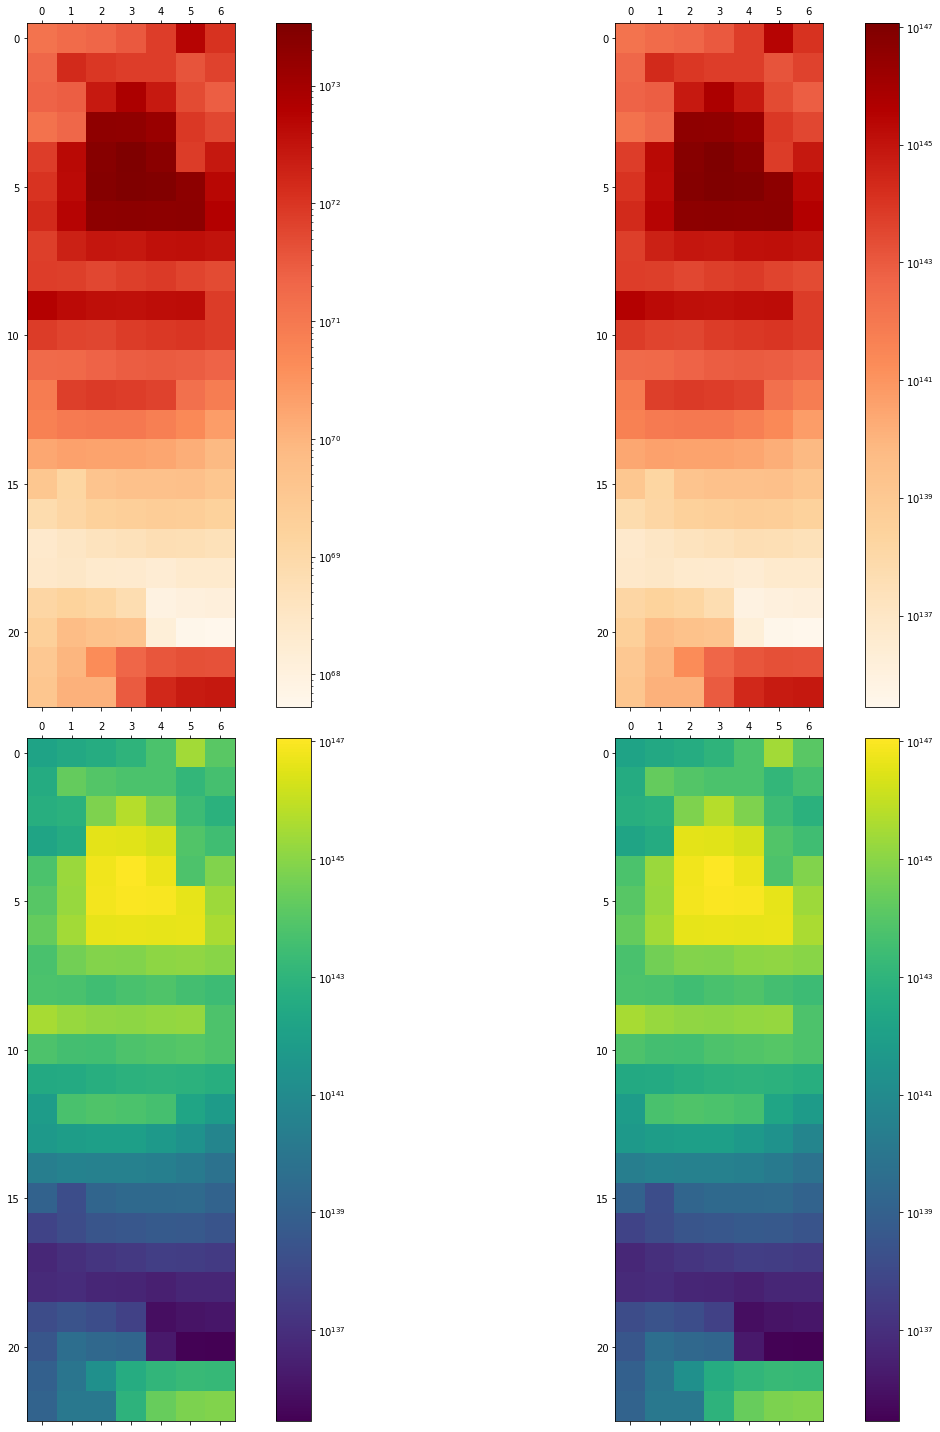

In [388]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

ax0 = axs[0][0].matshow(concentration_, cmap="OrRd", norm=mpl.colors.LogNorm())

ax1 = axs[0][1].matshow(out_matrix, cmap="OrRd", norm=mpl.colors.LogNorm())

ax2 = axs[1][0].matshow(concentration_array[0], norm=mpl.colors.LogNorm())

ax3 = axs[1][1].matshow(concentration_array[-1], norm=mpl.colors.LogNorm())
fig.colorbar(ax0, ax=axs[0][0])
fig.colorbar(ax1, ax=axs[0][1])
fig.colorbar(ax2, ax=axs[1][0])
fig.colorbar(ax3, ax=axs[1][1])

fig.tight_layout()



In [393]:
plt.scatter(initial_array)

TypeError: scatter() missing 1 required positional argument: 'y'

In [185]:
# BUS

# --> Airavata: implement ############# section ########## with user input instead of loop

# initialize: parameter loops

windows = ['up', 'down']
num_students = [56]
masks = [1, .9]
num_sims = 100
trip_length = 45


# table output: % chance of >= 1 infection over 1 bus trip

out_array = [[], []]
final_array = [[], []]

bus_trip_array = []


out_matrix = np.array(np.zeros(shape=bus_flow_direction.shape))

for w in range(len(windows)):

    for n in range(len(num_students)):
        
        for m in range(len(masks)):
            # windows up vs down # extrapolated from ACH ratio for open windows on bus
            # and open vs closed windows in a classroom (prior research)
            ##### verify this #####
            if windows[w] == 'up': # effective ACH = 5
                win_effect = 0.25
            if windows[w] == 'down': # effective ACH = 20
                win_effect = 1
            # bus_aerosol moved to bus.py

#             bus_aerosol = return_aerosol_transmission_rate(floor_area, mean_ceiling_height,
#                                     air_exchange_rate * win_effect,
#                                     aerosol_filtration_eff, relative_humidity, breathing_flow_rate,
#                                     exhaled_air_inf, max_viral_deact_rate, mask_passage_prob,
#                                     max_aerosol_radius=2, primary_outdoor_air_fraction=0.2)
            
    
            # conc is not averaged yet
            bus_trip, conc, avg_conc, chance_nonzero = bus_sim(windows[w], num_students[n], masks[m], num_sims, trip_length, '56')
            # this is an array of transmission % for each student on the trip
        
            # reference array
            out_array[m].append([windows[w],num_students[n],masks[m]]) # append value
            final_array[m].append(chance_nonzero)
            
            bus_trip_array.append(bus_trip)
            
            for y in range(len(avg_conc)):
                for x in range((len(avg_conc[0]))):
                    out_matrix[y][x] += (avg_conc[y][x]) / (len(windows) * len(num_students) * len(masks))
        
out_df = pd.DataFrame(out_array)
# out_df.columns = ['WinUp28', 'WinUp56', 'WinDown28', 'WinDown56']

# out_df.index = ['100%', '90%', '80%'] # mask wearing rate
out_df.columns = ['WinUp56', 'WinDown56']
out_df.index = ['100%', '90%']

out_df

# initialize: scatter

# output: scatterplot of distance from initial (X) vs Likelihood of infection (Y)
# Y: each point = 1 student, averaged over 100 reruns (random initial student, random infectivity)




# initialize: close_neighbors

# 5 students: KDEplot of % likelihood of infection over 1 trip


C:\Users\Bailey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bailey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,WinUp56,WinDown56
100%,"[up, 56, 1]","[down, 56, 1]"
90%,"[up, 56, 0.9]","[down, 56, 0.9]"


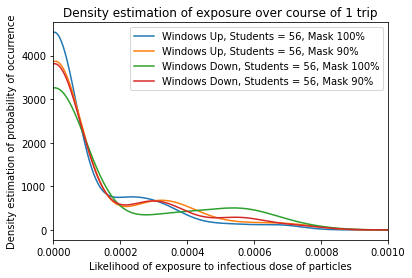

In [186]:

pd.Series(bus_trip_array[0]).plot.kde()
pd.Series(bus_trip_array[1]).plot.kde()
pd.Series(bus_trip_array[2]).plot.kde()
pd.Series(bus_trip_array[3]).plot.kde()
ax = plt.gca()
plt.title('Density estimation of exposure over course of 1 trip')
plt.xlim(0, .001)
# rescale y axis to be % based
plt.xlabel('Likelihood of exposure to infectious dose of particles')
plt.ylabel('Density estimation of probability of occurrence')
plt.legend(['Windows Up, Students = 56, Mask 100%', 'Windows Up, Students = 56, Mask 90%',
           'Windows Down, Students = 56, Mask 100%', 'Windows Down, Students = 56, Mask 90%'])

In [187]:
conc[0].shape

(23, 7)

In [188]:
final_df = pd.DataFrame(final_array)
# final_df.columns =['WinUp28', 'WinUp56', 'WinDown28', 'WinDown56']
# final_df.index = ['100%', '90%', '80%'] # mask wearing rate
final_df.columns = out_df.columns
final_df.index = out_df.index
final_df

,WinUp56,WinDown56
100%,0.036924,0.053547
90%,0.045458,0.044367


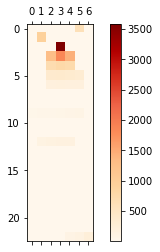

In [191]:

fig, ax1 = plt.subplots(1, 1)
temp = ax1.matshow(concentration_, cmap="OrRd")
# change axes

# check which students are initially selected



fig.colorbar(temp)
            
    
# square = .3 x .3 m 